In [41]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd

In [10]:
best_comb_filename = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/output/best_comb_cup.pkl'
param_grid_filename = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/output/param_grid_cup.pkl'

In [12]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv('/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/ML-CUP23-TR.csv', names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)
prova = df[:750]
X_train, y_train = prova[features].to_numpy().T, prova[targets].to_numpy().T
X_test, y_test = df[750:][features].to_numpy().T, df[750:][targets].to_numpy().T

In [29]:
best_comb = load_dict_from_file(best_comb_filename)
param_grid = load_dict_from_file(param_grid_filename)

In [46]:
# Print the best {how_many} hyperparameter sets by their {sorting_key}

how_many = 5 # how many elements to print
sorting_key = 'val_loss_mean' # value on which the sorting is performed
p_best = []

p_to_sort = [[x, x['results'][sorting_key]] for x in param_grid]
p_best_sorted = sorted(p_to_sort, key=lambda x:x[1])

for p_comb,loss in p_best_sorted[:how_many]:
    p_best.append(p_comb)
    tmp_dict = p_comb.copy()
    results = tmp_dict.pop('results')
    print(f"val_loss = {results['val_loss_mean']:.2e} +- {results['val_loss_std']:.2e}")
    print(f'hyperparameters : {tmp_dict}')
    print(f'results : {results}')
    print('')

val_loss = 1.03e+00 +- 1.79e-01
hyperparameters : {'eta': 0.1, 'lam': 0.0, 'alpha': 0.9, 'epochs': 500, 'n_batch': 128, 'scale_eta_batchsize': None, 'dim_hidden1': 15, 'hidden_act_func1': 'sigm', 'dim_hidden2': 20, 'hidden_act_func2': 'sigm', 'use_opt': 1, 'elapsed_time': 553.9261739253998}
results : {'train_loss_mean': 0.5201528668538551, 'train_loss_std': 0.13358786564353714, 'val_loss_mean': 1.0326004603677463, 'val_loss_std': 0.17901062003248525, 'train_MEE_mean': 1.105915116838164, 'train_MEE_std': 0.13404806220830068, 'val_MEE_mean': 1.462375071375924, 'val_MEE_std': 0.11547323154423764}

val_loss = 1.17e+00 +- 2.74e-01
hyperparameters : {'eta': 0.1, 'lam': 0.0, 'alpha': 0.9, 'epochs': 500, 'n_batch': 128, 'scale_eta_batchsize': None, 'dim_hidden1': 20, 'hidden_act_func1': 'sigm', 'dim_hidden2': 20, 'hidden_act_func2': 'sigm', 'use_opt': 1, 'elapsed_time': 615.9644541740417}
results : {'train_loss_mean': 0.44132417480019903, 'train_loss_std': 0.10828424831773398, 'val_loss_mean':

Epoch 0: train_loss: 7.157e+02, test_loss: 6.908e+02; train_MEE: 4.181e+01, test_MEE: 4.106e+01  lr : 0.1
Epoch 1: train_loss: 5.722e+02, test_loss: 5.591e+02; train_MEE: 3.843e+01, test_MEE: 3.826e+01  lr : 0.1
Epoch 2: train_loss: 4.892e+02, test_loss: 4.836e+02; train_MEE: 3.629e+01, test_MEE: 3.634e+01  lr : 0.1
Epoch 3: train_loss: 4.417e+02, test_loss: 4.335e+02; train_MEE: 3.446e+01, test_MEE: 3.438e+01  lr : 0.1
Epoch 4: train_loss: 3.982e+02, test_loss: 3.905e+02; train_MEE: 3.258e+01, test_MEE: 3.241e+01  lr : 0.1
Epoch 5: train_loss: 3.508e+02, test_loss: 3.513e+02; train_MEE: 3.034e+01, test_MEE: 3.049e+01  lr : 0.1
Epoch 6: train_loss: 3.114e+02, test_loss: 3.053e+02; train_MEE: 2.818e+01, test_MEE: 2.797e+01  lr : 0.1
Epoch 7: train_loss: 2.720e+02, test_loss: 2.666e+02; train_MEE: 2.610e+01, test_MEE: 2.583e+01  lr : 0.1
Epoch 8: train_loss: 2.311e+02, test_loss: 2.283e+02; train_MEE: 2.390e+01, test_MEE: 2.369e+01  lr : 0.1
Epoch 9: train_loss: 1.965e+02, test_loss: 1.9

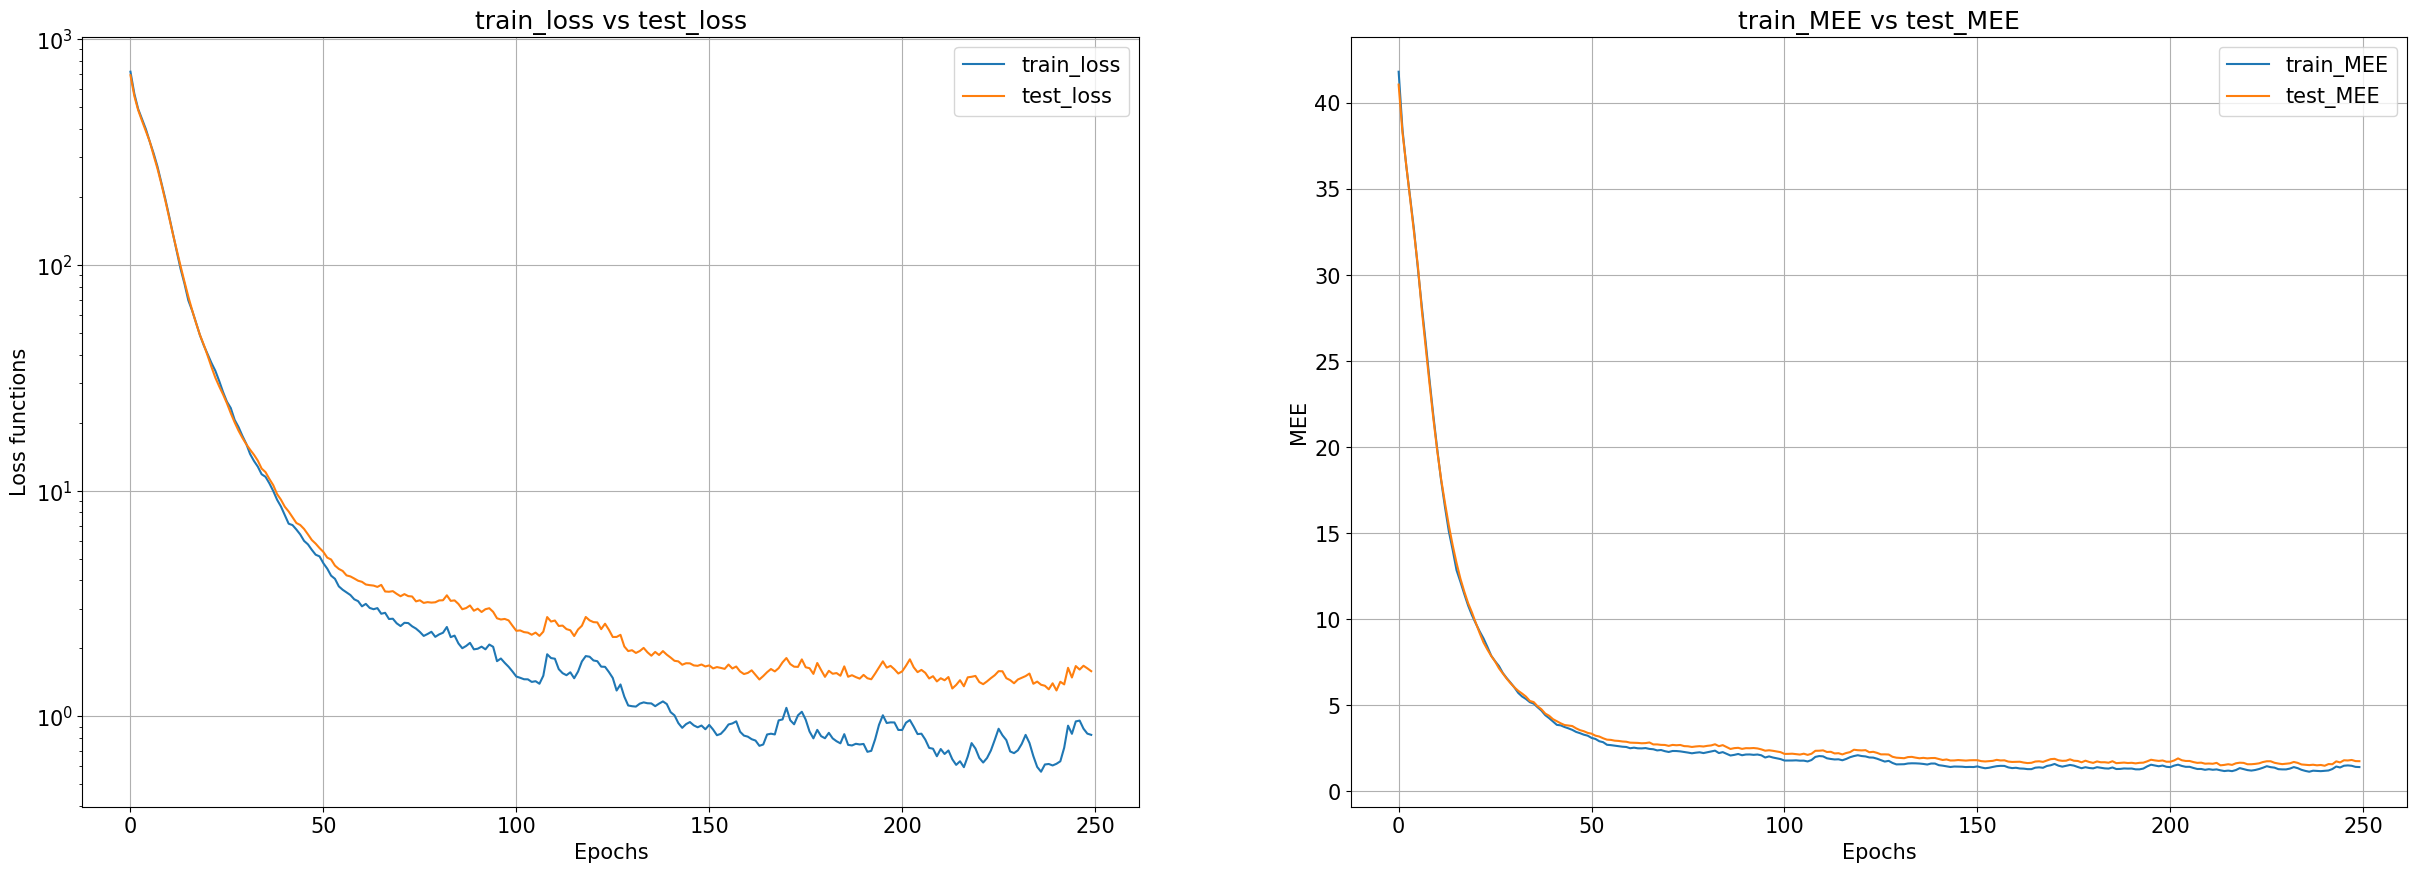

Epoch 0: train_loss: 6.598e+02, test_loss: 6.565e+02; train_MEE: 4.039e+01, test_MEE: 4.036e+01  lr : 0.1
Epoch 1: train_loss: 5.500e+02, test_loss: 5.474e+02; train_MEE: 3.825e+01, test_MEE: 3.837e+01  lr : 0.1
Epoch 2: train_loss: 5.130e+02, test_loss: 5.121e+02; train_MEE: 3.766e+01, test_MEE: 3.780e+01  lr : 0.1
Epoch 3: train_loss: 4.647e+02, test_loss: 4.644e+02; train_MEE: 3.567e+01, test_MEE: 3.584e+01  lr : 0.1
Epoch 4: train_loss: 4.107e+02, test_loss: 4.083e+02; train_MEE: 3.293e+01, test_MEE: 3.292e+01  lr : 0.1
Epoch 5: train_loss: 3.816e+02, test_loss: 3.735e+02; train_MEE: 3.124e+01, test_MEE: 3.095e+01  lr : 0.1
Epoch 6: train_loss: 3.562e+02, test_loss: 3.484e+02; train_MEE: 3.000e+01, test_MEE: 2.965e+01  lr : 0.1
Epoch 7: train_loss: 3.261e+02, test_loss: 3.215e+02; train_MEE: 2.855e+01, test_MEE: 2.829e+01  lr : 0.1
Epoch 8: train_loss: 3.004e+02, test_loss: 2.931e+02; train_MEE: 2.731e+01, test_MEE: 2.686e+01  lr : 0.1
Epoch 9: train_loss: 2.646e+02, test_loss: 2.6

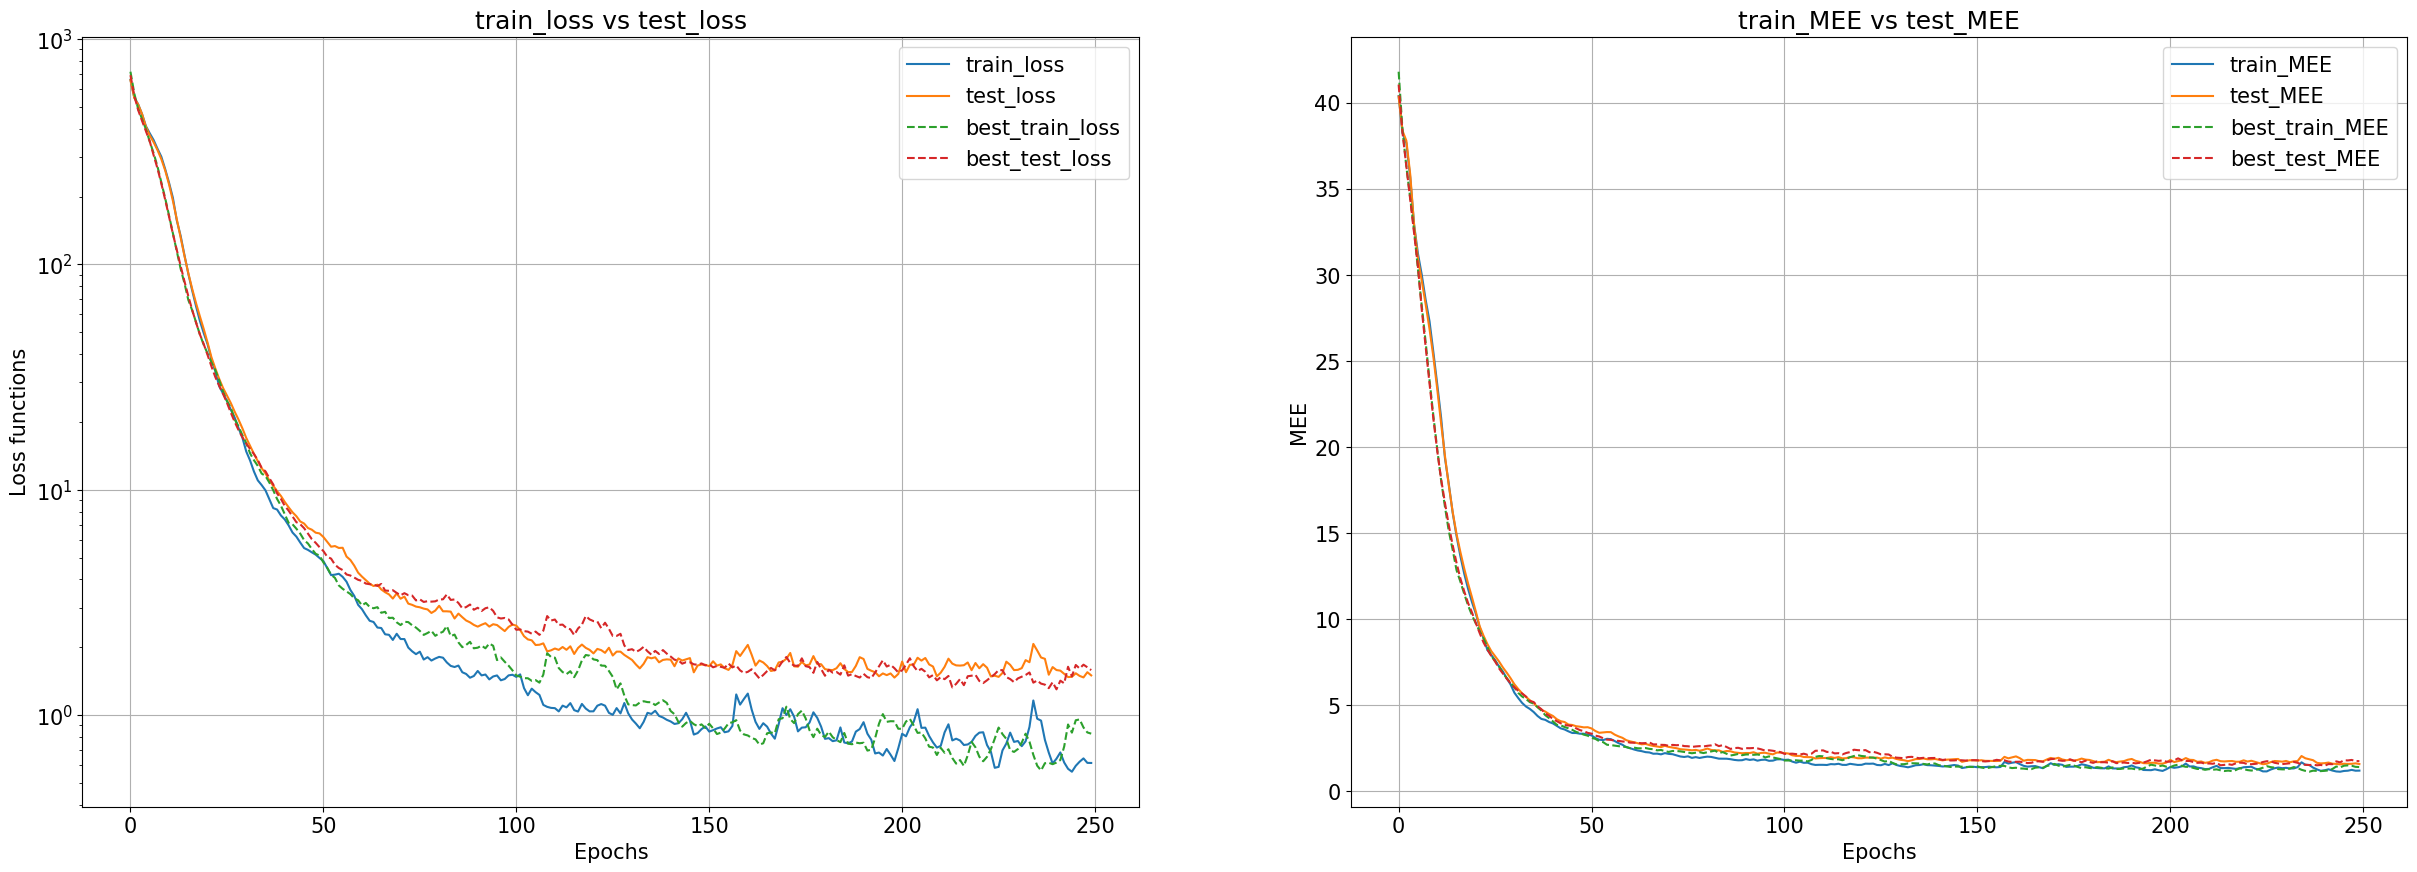

Epoch 0: train_loss: 6.980e+02, test_loss: 6.803e+02; train_MEE: 4.112e+01, test_MEE: 4.068e+01  lr : 0.1
Epoch 1: train_loss: 5.593e+02, test_loss: 5.465e+02; train_MEE: 3.823e+01, test_MEE: 3.805e+01  lr : 0.1
Epoch 2: train_loss: 4.865e+02, test_loss: 4.805e+02; train_MEE: 3.626e+01, test_MEE: 3.625e+01  lr : 0.1
Epoch 3: train_loss: 4.419e+02, test_loss: 4.355e+02; train_MEE: 3.469e+01, test_MEE: 3.459e+01  lr : 0.1
Epoch 4: train_loss: 4.016e+02, test_loss: 3.957e+02; train_MEE: 3.288e+01, test_MEE: 3.277e+01  lr : 0.1
Epoch 5: train_loss: 3.574e+02, test_loss: 3.514e+02; train_MEE: 3.074e+01, test_MEE: 3.054e+01  lr : 0.1
Epoch 6: train_loss: 3.189e+02, test_loss: 3.095e+02; train_MEE: 2.868e+01, test_MEE: 2.829e+01  lr : 0.1
Epoch 7: train_loss: 2.805e+02, test_loss: 2.773e+02; train_MEE: 2.677e+01, test_MEE: 2.663e+01  lr : 0.1
Epoch 8: train_loss: 2.529e+02, test_loss: 2.465e+02; train_MEE: 2.515e+01, test_MEE: 2.488e+01  lr : 0.1
Epoch 9: train_loss: 2.230e+02, test_loss: 2.1

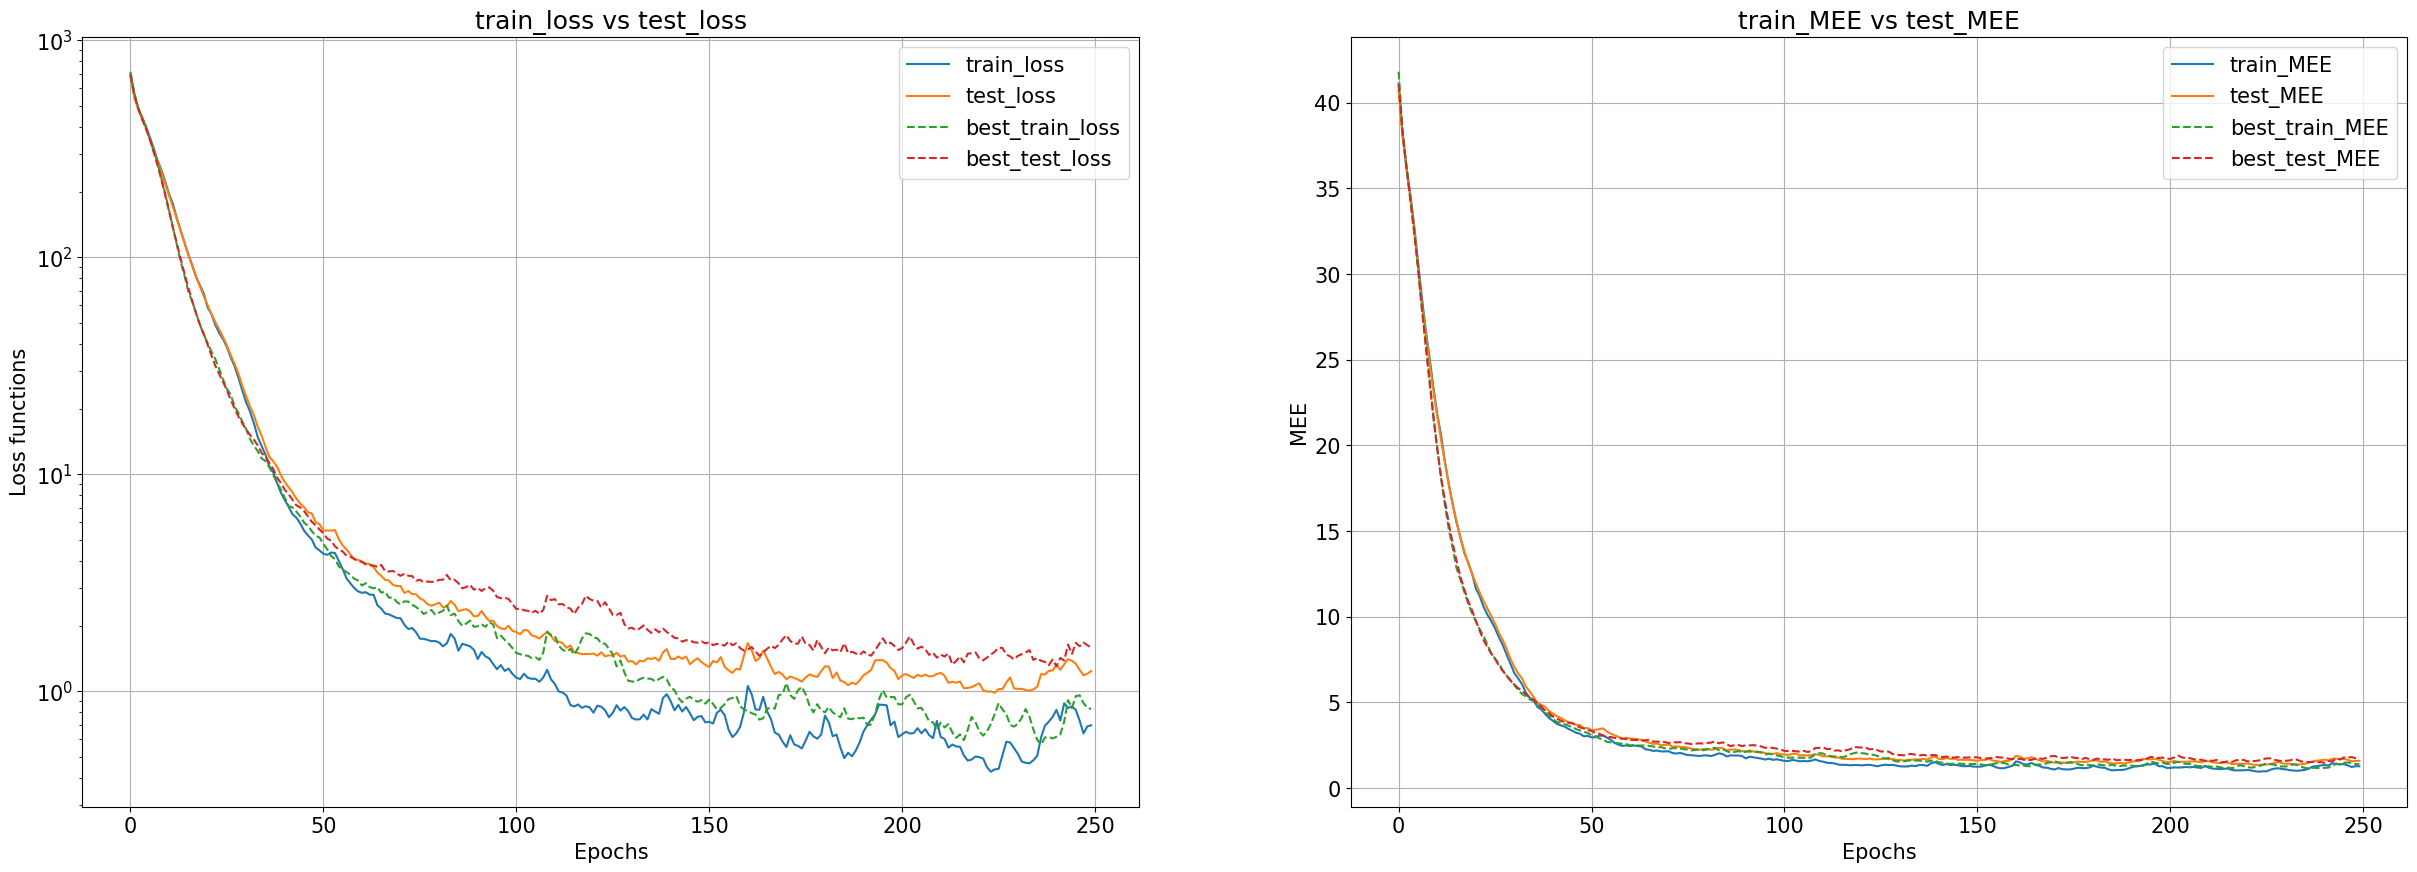

Epoch 0: train_loss: 6.998e+02, test_loss: 6.845e+02; train_MEE: 4.122e+01, test_MEE: 4.078e+01  lr : 0.1
Epoch 1: train_loss: 5.717e+02, test_loss: 5.707e+02; train_MEE: 3.824e+01, test_MEE: 3.842e+01  lr : 0.1
Epoch 2: train_loss: 5.068e+02, test_loss: 5.134e+02; train_MEE: 3.673e+01, test_MEE: 3.722e+01  lr : 0.1
Epoch 3: train_loss: 4.963e+02, test_loss: 4.881e+02; train_MEE: 3.683e+01, test_MEE: 3.673e+01  lr : 0.1
Epoch 4: train_loss: 4.812e+02, test_loss: 4.772e+02; train_MEE: 3.642e+01, test_MEE: 3.645e+01  lr : 0.1
Epoch 5: train_loss: 4.666e+02, test_loss: 4.613e+02; train_MEE: 3.575e+01, test_MEE: 3.571e+01  lr : 0.1
Epoch 6: train_loss: 4.374e+02, test_loss: 4.345e+02; train_MEE: 3.434e+01, test_MEE: 3.435e+01  lr : 0.1
Epoch 7: train_loss: 4.103e+02, test_loss: 4.037e+02; train_MEE: 3.276e+01, test_MEE: 3.260e+01  lr : 0.1
Epoch 8: train_loss: 3.886e+02, test_loss: 3.825e+02; train_MEE: 3.152e+01, test_MEE: 3.134e+01  lr : 0.1
Epoch 9: train_loss: 3.776e+02, test_loss: 3.6

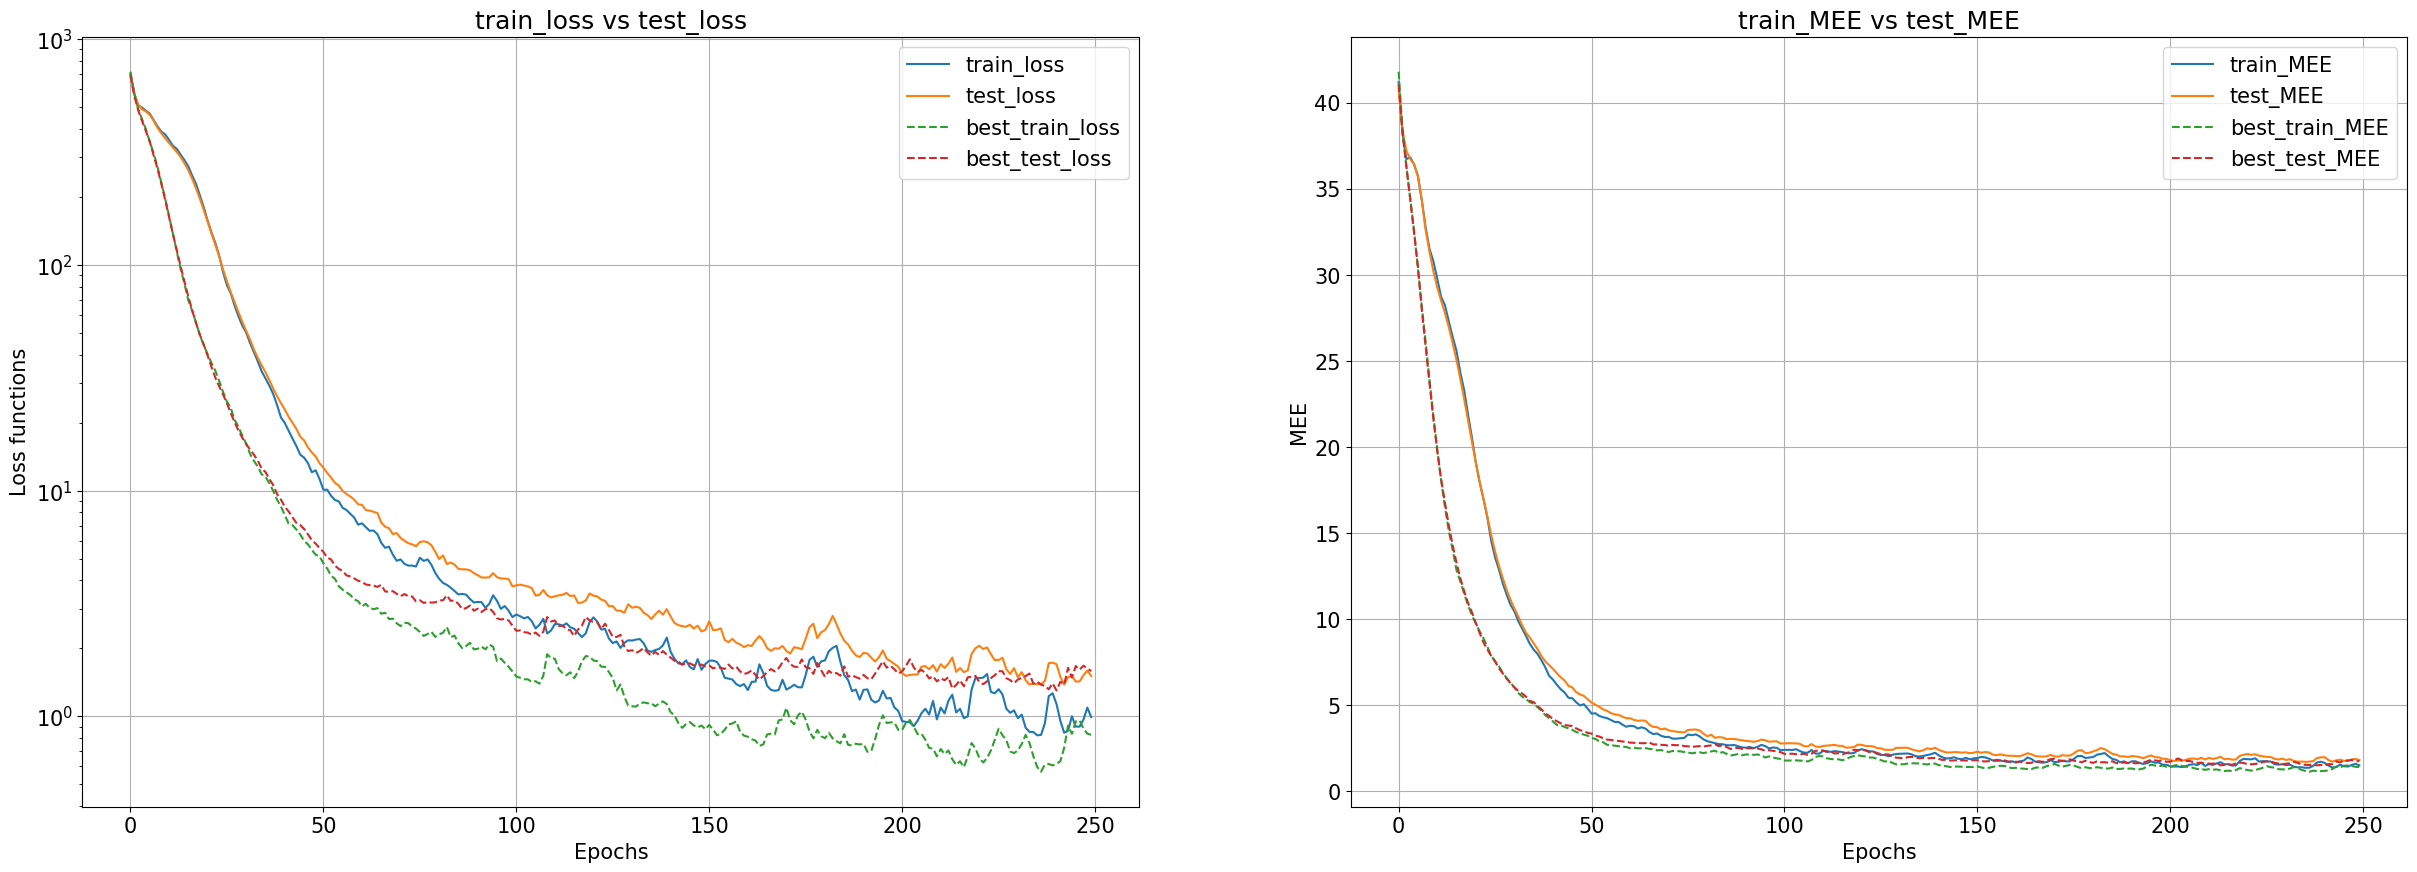

Epoch 0: train_loss: 6.989e+02, test_loss: 6.802e+02; train_MEE: 4.126e+01, test_MEE: 4.080e+01  lr : 0.1
Epoch 1: train_loss: 5.751e+02, test_loss: 5.627e+02; train_MEE: 3.885e+01, test_MEE: 3.860e+01  lr : 0.1
Epoch 2: train_loss: 5.170e+02, test_loss: 5.118e+02; train_MEE: 3.768e+01, test_MEE: 3.771e+01  lr : 0.1
Epoch 3: train_loss: 4.616e+02, test_loss: 4.576e+02; train_MEE: 3.546e+01, test_MEE: 3.549e+01  lr : 0.1
Epoch 4: train_loss: 4.001e+02, test_loss: 3.952e+02; train_MEE: 3.262e+01, test_MEE: 3.253e+01  lr : 0.1
Epoch 5: train_loss: 3.476e+02, test_loss: 3.400e+02; train_MEE: 2.996e+01, test_MEE: 2.972e+01  lr : 0.1
Epoch 6: train_loss: 3.019e+02, test_loss: 2.982e+02; train_MEE: 2.765e+01, test_MEE: 2.754e+01  lr : 0.1
Epoch 7: train_loss: 2.641e+02, test_loss: 2.599e+02; train_MEE: 2.572e+01, test_MEE: 2.549e+01  lr : 0.1
Epoch 8: train_loss: 2.200e+02, test_loss: 2.210e+02; train_MEE: 2.330e+01, test_MEE: 2.334e+01  lr : 0.1
Epoch 9: train_loss: 1.848e+02, test_loss: 1.8

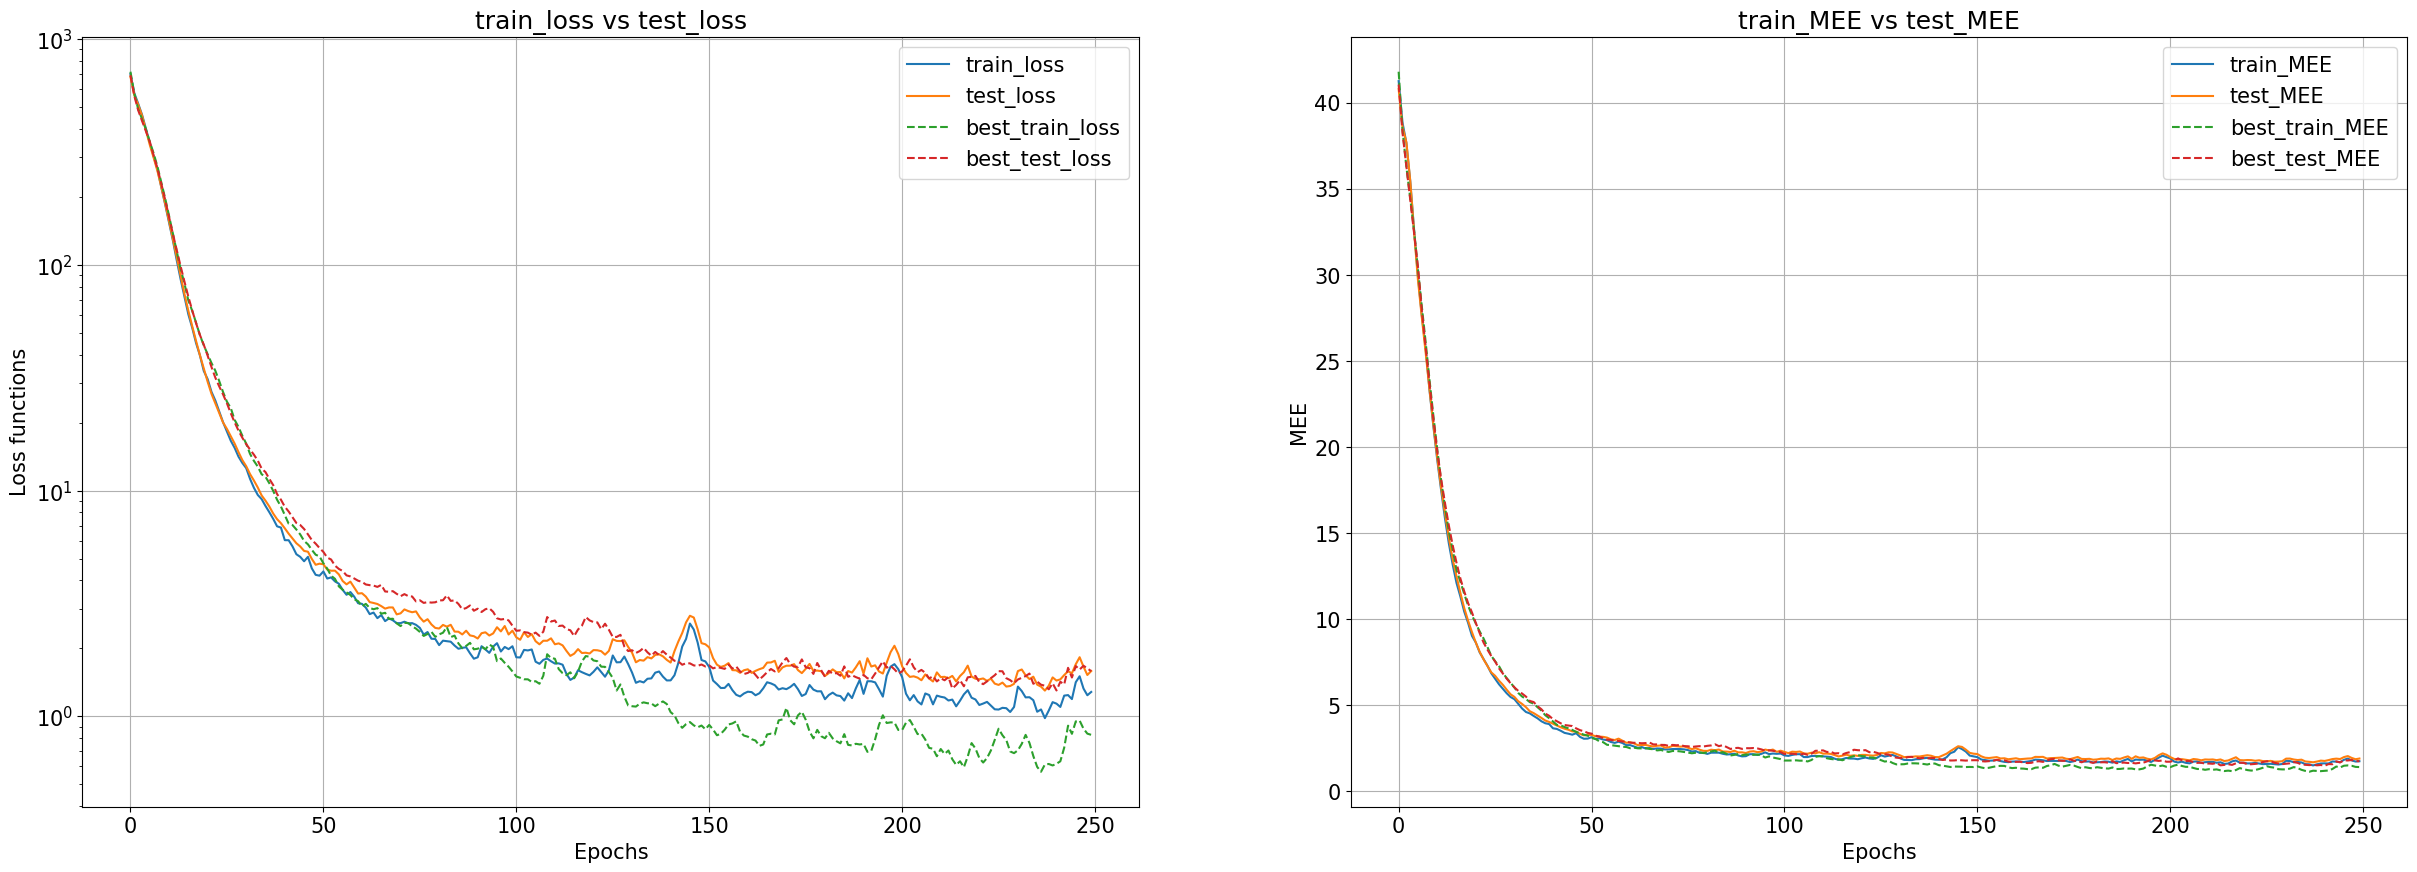

In [54]:
# Permorm retraining on the best {how_many} sets and print loss and MEE graphs.

retraining_epochs = 250
print_best = True # print the best results on all graphs

for i,p_comb in enumerate(p_best):

    best_comb = p_comb.copy()
    #------------------------------------------------superfluo
    best_comb['loss'] = 'MSE'
    best_comb['output_act_func'] = 'lin'
    best_comb['epochs'] = retraining_epochs
    #------------------------------------------------
    results = best_comb.pop('results')
    if best_comb['n_batch'] == 'batch':
        best_comb['n_batch'] = X_train.shape[1]
    elapsed_time = best_comb.pop('elapsed_time')
    if best_comb['scale_eta_batchsize'] == 'lin':
        best_comb['eta'] = best_comb['eta'] * best_comb['n_batch']
    if best_comb['scale_eta_batchsize'] == 'sqrt':
        best_comb['eta'] = best_comb['eta'] * np.sqrt(best_comb['n_batch'])
    best_comb.pop('scale_eta_batchsize')

    # ----------------------- MODEL ----------------------------
    
    input_layer = Input(X_train.shape[0])
    hidden_layer = Layer(input_layer, best_comb.pop('dim_hidden1'), best_comb.pop('hidden_act_func1'))
    o = 2
    while True:
        if f'dim_hidden{o}' in best_comb.keys():
            hidden_layer = Layer(hidden_layer, best_comb.pop(f'dim_hidden{o}'), best_comb.pop(f'hidden_act_func{o}'))
        else: break
    output_layer = Layer(hidden_layer, 3, best_comb.pop('output_act_func'))

    model = NeuralNetwork(input_layer, output_layer, best_comb.pop('loss'), metrics=[MEE])
    history = model.retrain(X_train, y_train.reshape((3,X_train.shape[1])), test_data = [X_test,y_test.reshape((3,X_test.shape[1]))], **best_comb)

    # ----------------------------------------------------------

    if i == 0:
        best_train_loss, best_test_loss = history['train_loss'], history['test_loss']
        best_train_MEE, best_test_MEE = history['train_MEE'], history['test_MEE']

    plt.figure(i, figsize=(30,10))
    
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['test_loss'], label='test_loss')
    if (i > 0) and (print_best == True):
        plt.plot(best_train_loss,'--',label='best_train_loss')
        plt.plot(best_test_loss, '--', label='best_test_loss')
    plt.yscale('log')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Loss functions', size=15)
    plt.title('train_loss vs test_loss', size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.legend(fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history['train_MEE'],label='train_MEE')
    plt.plot(history['test_MEE'], label='test_MEE')
    if (i > 0) and (print_best == True):
        plt.plot(best_train_MEE,'--',label='best_train_MEE')
        plt.plot(best_test_MEE, '--', label='best_test_MEE')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('MEE', size=15)
    plt.title('train_MEE vs test_MEE', size=18)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.legend(fontsize=15)

    plt.show()